In [ ]:
!pip install pandas
!pip install matplotlib
# Використаємо pulp через її простотоу і легкість читання коду
!pip install pulp

In [252]:
import pandas as pd
import numpy as np


Outline:

EDA:
- Перший погляд на дані
- Аналіз delta_time в часі
- Аналіз деяких розподілів

Assigment Problem:
- Data preprocessing
- Assigment Alg
- Results

In [253]:
task_path = "Test task (Operations Research Scientist) (1).xlsx"
logdata = pd.read_excel(task_path, sheet_name="data_2")
logdata

,log_id,worker_id,process_name,item_id,time_from,time_to
0,1,worker_1,collection,item_3,2025-07-20 11:54:42,2025-07-20 11:55:12.606
1,2,worker_1,collection,item_4,2025-07-01 18:25:48,2025-07-01 18:26:15.158
2,3,worker_1,transfer,item_3,2025-07-15 22:13:18,2025-07-15 22:14:10.923
3,4,worker_1,collection,item_5,2025-07-21 22:35:23,2025-07-21 22:35:50.028
4,5,worker_1,collection,item_4,2025-07-16 09:56:37,2025-07-16 09:57:01.921
...,...,...,...,...,...,...
3995,3996,worker_5,placement,item_2,2025-09-14 10:04:23,2025-09-14 10:05:16.358
3996,3997,worker_5,placement,item_4,2025-09-07 17:25:54,2025-09-07 17:26:40.309
3997,3998,worker_5,placement,item_3,2025-09-25 18:05:47,2025-09-25 18:06:49.291
3998,3999,worker_5,transfer,item_1,2025-09-02 17:38:11,2025-09-02 17:39:07.979


```delta_time``` - час виконання певного процесу з певним предметом певним працівником

In [255]:
logdata["delta_time"] = (logdata["time_to"] - logdata["time_from"]).dt.total_seconds()

# EDA

## Перший погляд на дані

array([[<Axes: title={'center': 'delta_time'}>]], dtype=object)

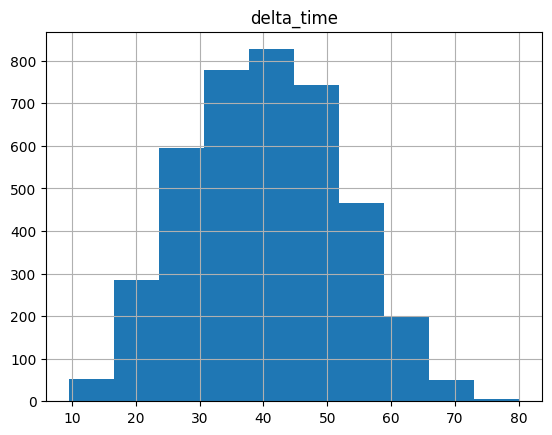

In [195]:
logdata[["delta_time"]].hist()

Припущення:
1. Завдання це комбінація item_id x process_name = task
2. Час виконання завдання = time_to - time_from = delta_time

Спостережння:
Всі задачі виконуються будь яким працівником менше ніж за 1.5хв. Загалом, до даних є відразу питань з точки зору common sense:
1. "transfer" - Переміщення товару між складами зберігання - зробити це умовно за 1хв видається нереальним, якщо між "складами" є хоча б 50 метрів відстані, наприклад
2. Обмеження в 3 задачі на працівника: роботи на день менше ніж на 5хв
3. Загальний обʼєм роботи на день: 8 задач < 12хв

Якщо ці припущення валідні, то спостереження можуть бути пояснені "іграшковістю" задачки. 

In [201]:
logdata["date"] = pd.to_datetime(pd.to_datetime(logdata["time_from"]).dt.date)
logdata["weekday"] = logdata["date"].dt.weekday
logdata["task"] = logdata["item_id"] + "_" + logdata["process_name"]
logdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   log_id        4000 non-null   int64         
 1   worker_id     4000 non-null   object        
 2   process_name  4000 non-null   object        
 3   item_id       4000 non-null   object        
 4   time_from     4000 non-null   datetime64[ns]
 5   time_to       4000 non-null   datetime64[ns]
 6   delta_time    4000 non-null   float64       
 7   date          4000 non-null   datetime64[ns]
 8   weekday       4000 non-null   int32         
 9   task          4000 non-null   object        
dtypes: datetime64[ns](3), float64(1), int32(1), int64(1), object(4)
memory usage: 297.0+ KB


1. Якщо працівник виконував якусь задачу, про це є як мінімум 40 записів в логах - цілком доцільно буде взяти медіану для оцінки часу на виконння завдання
2. Всі працівники взаємодіяли з усіма предметами
3. Worker_id = 2 не має записів про placement - маємо 2 гіпотези, які можна буде реалізувати далі в коді:
    - 3.1. Цей тип роботи не призначається працівнику, при пошуку оптимального рішення потрібно буде застосувати penalty, щоб алгоритм ігнорував таку комбінацію
    - 3.2. В нас неповні дані, або ж 3.1. валідний лише для історичних даних і ми хочемо, щоб цей працівник виконував цю задачу - data imptutation 

<Axes: >

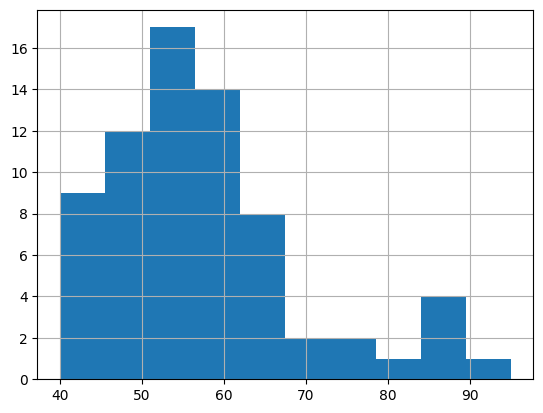

In [218]:

logdata.groupby(["worker_id", "task"]).count()["log_id"].hist()

In [219]:
logdata.groupby(["item_id"]).nunique()["worker_id"], logdata.groupby(["worker_id"]).nunique()["task"], logdata.groupby(["worker_id"]).nunique()["process_name"]

(item_id
 item_1    5
 item_2    5
 item_3    5
 item_4    5
 item_5    5
 Name: worker_id, dtype: int64,
 worker_id
 worker_1    15
 worker_2    10
 worker_3    15
 worker_4    15
 worker_5    15
 Name: task, dtype: int64,
 worker_id
 worker_1    3
 worker_2    2
 worker_3    3
 worker_4    3
 worker_5    3
 Name: process_name, dtype: int64)

In [199]:
logdata.groupby(["worker_id", "task"], as_index=False).agg(
    {"delta_time": ["median", "std"]}
)

worker_id               task delta_time          
                                    median       std
0   worker_1  item_1_collection    25.6800  6.239880
1   worker_1   item_1_placement    33.6655  6.718855
2   worker_1    item_1_transfer    43.2810  7.681385
3   worker_1  item_2_collection    26.1280  7.624283
4   worker_1   item_2_placement    33.9805  6.019903
..       ...                ...        ...       ...
65  worker_5   item_4_placement    49.3770  5.117496
66  worker_5    item_4_transfer    60.7180  5.598461
67  worker_5  item_5_collection    46.6080  5.729448
68  worker_5   item_5_placement    52.8975  4.149204
69  worker_5    item_5_transfer    60.9830  5.167906

[70 rows x 4 columns]

## Аналіз delta_time в часі

In [225]:
from task_2_vis_utils import plot_series_grid, plot_dist_grid

ImportError: cannot import name 'plot_dist_grid' from 'task_2_utils' (/Users/denys.b/Documents/my/mymy/task_2_utils.py)

З графіків відразу видно, що час виконання завдань worker_1 різко зріс з Вер.2025, упускаючи причини, ```варто відфільтрувати дані по цій даті``` (для простоти для всіх працівників)

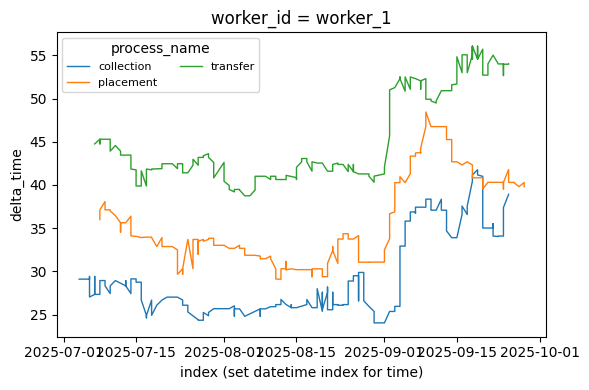

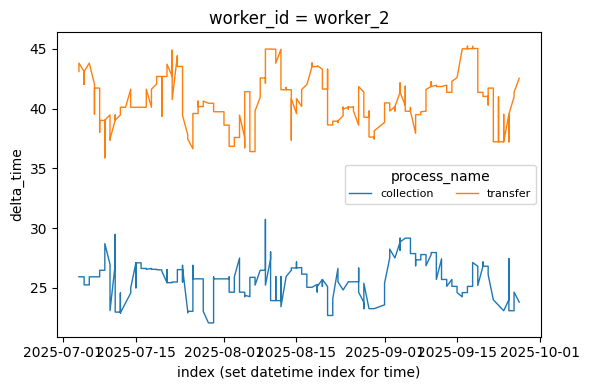

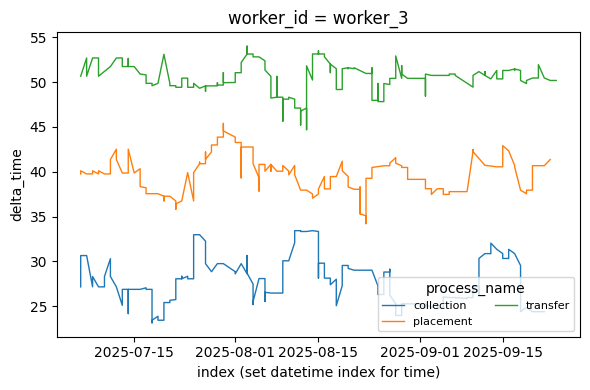

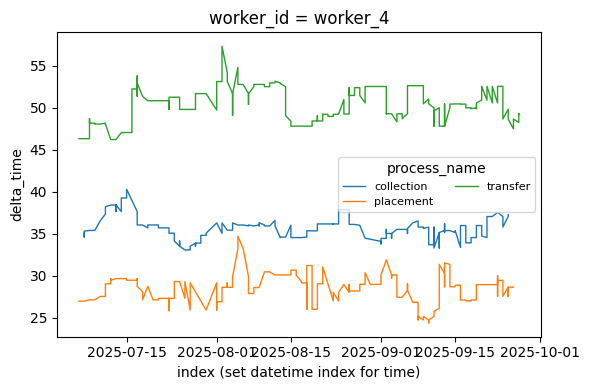

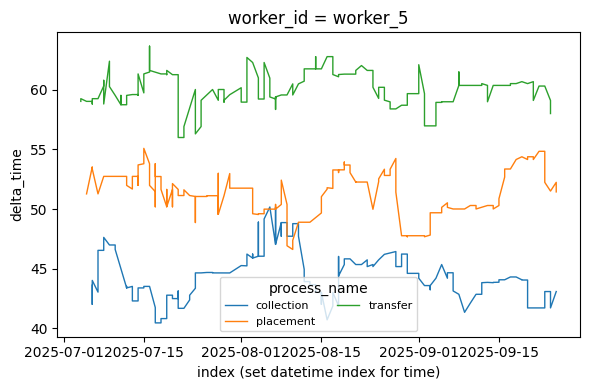

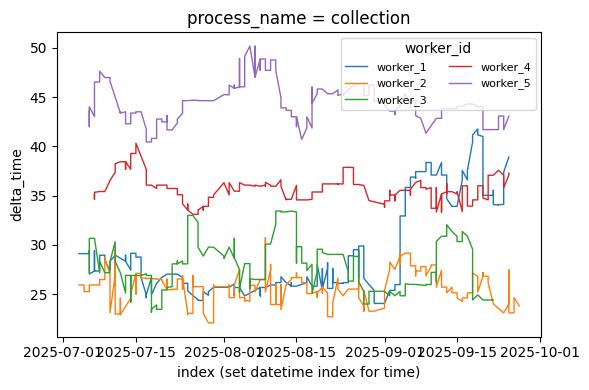

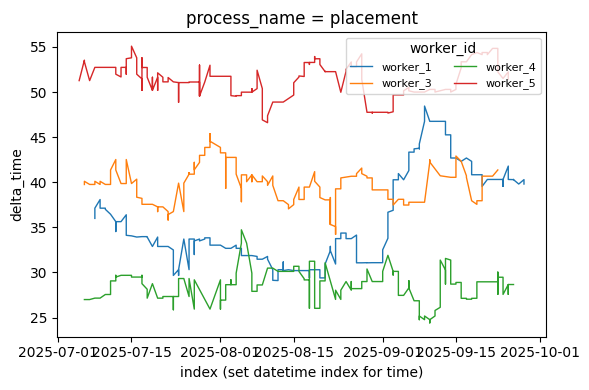

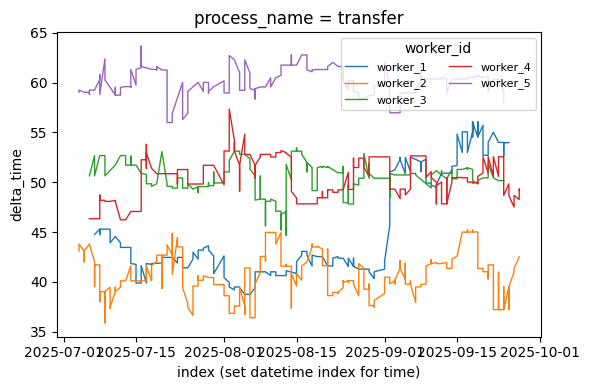

In [226]:
df = logdata.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").set_index("date")  # time on X

plot_series_grid(df, metric_col="delta_time", plot_col="worker_id", color_col="process_name", smoothing_win=15)
plot_series_grid(df, metric_col="delta_time", plot_col="process_name", color_col="worker_id", smoothing_win=15)

```Новий основний dataframe```

In [227]:
df_last_period = logdata.loc[logdata["date"] > '2025-09-01']


## Аналіз деяких розподілів

Візуально від дня тижня час виконання не сильно залежить (в ідеалі провести стастичний тест). 

Корисно перевірити залежність від пори дня - якщо список задач буде справді на весь день і планування треба зробити точнішим.

Місяці / пори року не розглядаємо, бо вже відфільтрували по осені. Від сильних аутлаєрів повʼязаних зі святами і тд нас захищає медіана, але це працює, тому що в нас простий іграшковий приклад

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


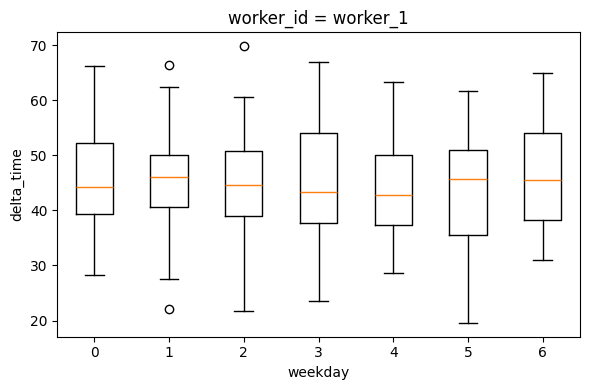

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


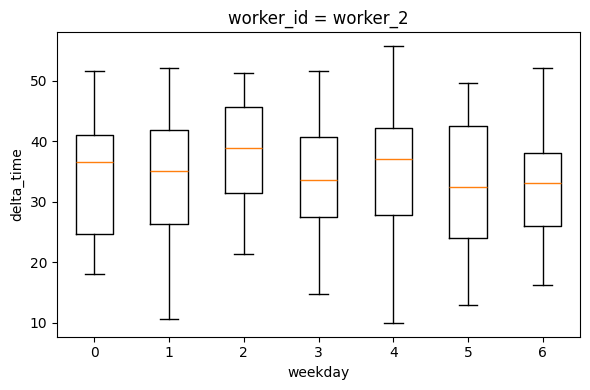

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


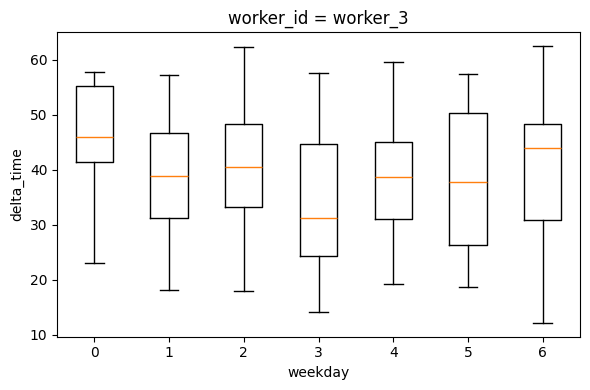

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


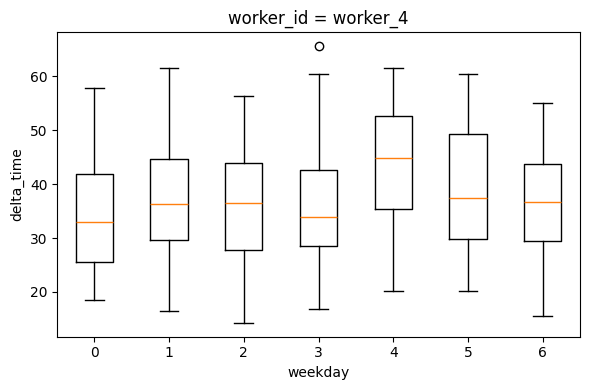

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


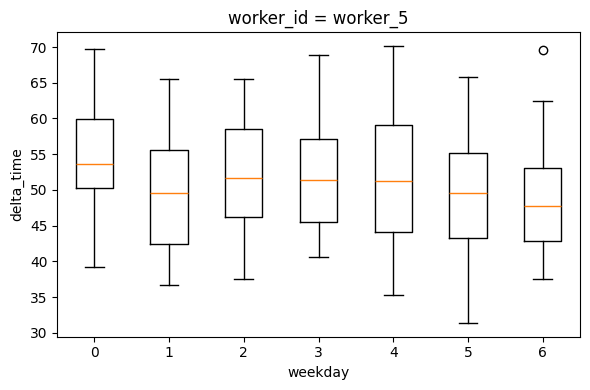

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


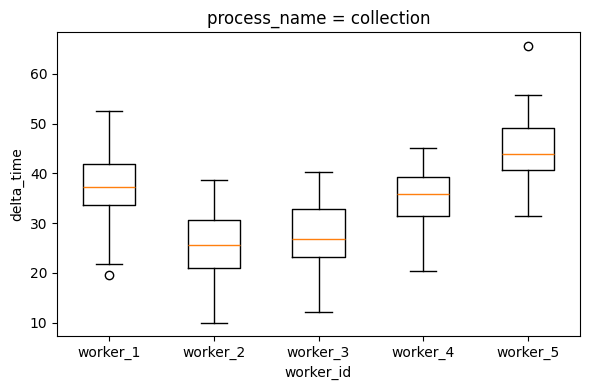

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


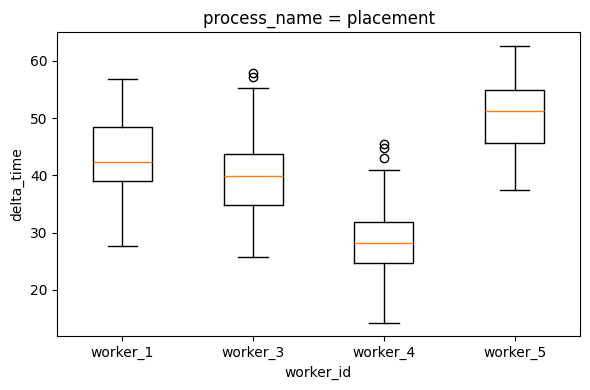

/var/folders/ff/98gx5v2558s6b620r3t_gppr0000gn/T/ipykernel_20066/1675387247.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=labels, showfliers=True)


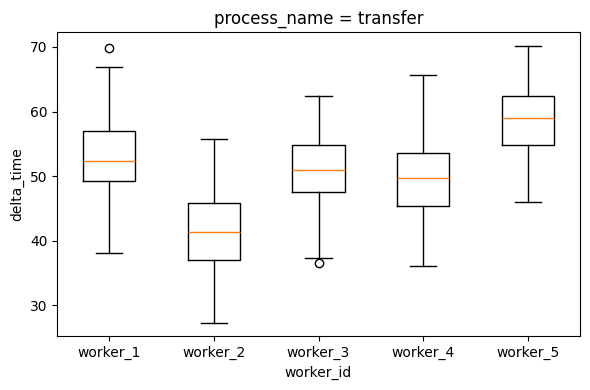

In [13]:
plot_dist_grid(df_last_period, metric_col="delta_time", plot_col="worker_id", color_col="weekday", plot_type='box')
plot_dist_grid(df_last_period, metric_col="delta_time", plot_col="process_name", color_col="worker_id", plot_type='box')


# Assigment Problem

In [230]:
import pulp
from typing import Tuple, List, Dict

In [ ]:
# Зручне представлення
from enum import Enum

class ProcessName(Enum):
    PLACEMENT = "placement"
    COLLECTION = "collection"
    TRANSFER = "transfer"

In [ ]:
# Завдання для воркерів з ексель файлу
tasks_for_day = (
    (1, ProcessName.PLACEMENT),
    (1, ProcessName.COLLECTION),
    (2, ProcessName.COLLECTION),
    (3, ProcessName.TRANSFER),
    (3, ProcessName.PLACEMENT),
    (3, ProcessName.COLLECTION),
    (4, ProcessName.PLACEMENT),
    (5, ProcessName.TRANSFER),
)

# id працівників
workers = (1, 2, 3, 4, 5)

# Приведенння значень до string щоб бути консистентними з logdata (в ідеалі потрібно робити навпаки і не оперувати строками worker_1, item_1, etc)
tasks_for_day = tuple((f"item_{t[0]}", t[1].value) for t in tasks_for_day)
workers = tuple(f"worker_{w}" for w in workers)


## Data preprocessing

Препроцесинг логу і преведення до костів завдань:

В нашому випадку ми не маємо костів лише для worker_2 x placement, але в ідеалі варто передбачити, що не всі працівники взаємодіяли з усіма предеметами / завданнями, а отже потрібно мати кост для всіх можливих комбінацій.
Далі є 2 стратегії:
    1. Якщо все ж ця комбінація справді не може бути втілена - залишаємо NaN (в алгоритмі потрібно буде примінити penalty)
    2. Якщо все ж ця комбінація можлива - імпутація даних. Тут я вирішив взяти AVG(worker avarage process time, other workers task time) - таким чином врахувати перформанс конкретного працівника по іншим задачам і середній перформанс для цієї задачі по іншим працівникам.


In [234]:

def prepare_costs(df: pd.DataFrame, fill_worker_wo_process: bool = False) -> Dict:
    workers = sorted(df['worker_id'].unique())
    items = sorted(df['item_id'].unique())
    processes = sorted(df['process_name'].unique())

    all_combinations = pd.MultiIndex.from_product(
        [workers, items, processes], 
        names=['worker_id', 'item_id', 'process_name']
    ).to_frame(index=False)

    worker_proc_avg = df.groupby(['worker_id', 'process_name'])['delta_time'].mean().reset_index()
    worker_proc_avg.rename(columns={'delta_time': 'avg_worker_proc'}, inplace=True)

    task_avg = df.groupby(['item_id', 'process_name'])['delta_time'].mean().reset_index()
    task_avg.rename(columns={'delta_time': 'avg_task_others'}, inplace=True)

    df_full = pd.merge(all_combinations, worker_proc_avg, on=['worker_id', 'process_name'], how='left')
    df_full = pd.merge(df_full, task_avg, on=['item_id', 'process_name'], how='left')
    
    # Усереднена імпутація даних
    df_full['hybrid_imputation'] = (df_full['avg_worker_proc'] + df_full['avg_task_others']) / 2
    # Якщо з цією задачею ніхто раніше не працював - avg_worker_proc
    df_full['hybrid_imputation'] = df_full['hybrid_imputation'].fillna(df_full['avg_worker_proc'])
    
    if fill_worker_wo_process:
        # Якщо працівник не виконував цей процес - avg_task_others
        # Якщо ця умова fill_worker_wo_process = False - для цього працівника і задачі в нас буде NaN
        df_full['hybrid_imputation'] = df_full['hybrid_imputation'].fillna(df_full['avg_task_others'])

    actual_medians = df.groupby(['worker_id', 'item_id', 'process_name'])['delta_time'].median().reset_index()
    
    df_final = pd.merge(df_full, actual_medians, on=['worker_id', 'item_id', 'process_name'], how='left')
    # delta_time тут — це фактична медіана з actual_medians
    df_final['final_time'] = df_final['delta_time'].fillna(df_final['hybrid_imputation'])

    # Повертаємо словник з костами
    costs = df_final.set_index(['worker_id', 'item_id', 'process_name'])['final_time'].to_dict()
    return costs


## Assigment Alg

Розглядається 2 функції: 
1. ```efficiency - efficiency_pulp()``` - мінімізуємо сумарний час виконання - корисно, якщо ми хочемо ефективно загрузити наших працвників (і наприклад почати брати завдання з іншому пулу завдань)

2. ```makespan - makespan_pulp()``` - мінімузуємо сумарний час виконання своїх задач найповільнішим працівником - корисно, якщо ми хочемо якумога швидше закрити пул задач (наприклад перед відкриттям магазину)

In [245]:

class AssignTasks:
    def __init__(self,
                 workers: List[str],
                 tasks_to_assign: List[Tuple],
                 task_costs: Dict,
                 penalty: float = None,
                 min_max_tasks: Tuple[int, int] = (0, 3)):
        
        self.workers = workers
        self.tasks_to_assign = tasks_to_assign
        self.task_costs = task_costs
        # Якщо penalty не задано, беремо max * 10 
        self.penalty = penalty if penalty is not None else max(task_costs.values()) * 10
        self.min_max_tasks = min_max_tasks

        # Якщо отримуємо невідомі кости - припускаємо, що ця комбінація не повинна бути використана - караємо penalty
        self._penalty_costs()

    def _penalty_costs(self):
        self.task_costs = {t: self.penalty if np.isnan(c) else c for t,c in self.task_costs.items()}

    def common_constains(self, x, prob):
        # Обмеження 1: Кожне завдання — 1 раз
        for t_idx in range(len(self.tasks_to_assign)):
            prob += pulp.lpSum(x[w, t_idx] for w in self.workers) == 1

        # Обмеження 2: Діапазон завдань на воркера
        for w in self.workers:
            worker_load = pulp.lpSum(x[w, t_idx] for t_idx in range(len(self.tasks_to_assign)))
            prob += worker_load >= self.min_max_tasks[0]
            prob += worker_load <= self.min_max_tasks[1]

        return prob

    def efficiency_pulp(self):
        prob = pulp.LpProblem("Task_Optimization", pulp.LpMinimize)

        # x[worker, task_index]
        x = pulp.LpVariable.dicts("assign", 
                                ((w, t) for w in self.workers for t in range(len(self.tasks_to_assign))), 
                                cat=pulp.LpBinary)

        # цільова функція для Efficiency (мінімізація суми)
        prob += pulp.lpSum(
            # penalty as failsafe in case _penalty_costs didn't properly work
            self.task_costs.get((w, self.tasks_to_assign[t][0], self.tasks_to_assign[t][1]), self.penalty) * x[w, t]
            for w in self.workers for t in range(len(self.tasks_to_assign))
        )

        prob = self.common_constains(x, prob)

        return prob, x

    def makespan_pulp(self):
        prob = pulp.LpProblem("Task_Optimization", pulp.LpMinimize)
        
        x = pulp.LpVariable.dicts("assign", 
                            ((w, t) for w in self.workers for t in range(len(self.tasks_to_assign))), 
                            cat=pulp.LpBinary)

        prob = self.common_constains(x, prob)    

        # цільова функція для Makespan (мінімізація найповільнішого працівника)
        M = pulp.LpVariable("M", lowBound=0)
        prob += M # Нова ціль — мінімізація M

        for w in self.workers:
            worker_time = pulp.lpSum(
                self.task_costs.get((w, self.tasks_to_assign[t][0], self.tasks_to_assign[t][1]), self.penalty) * x[w, t]
                for t in range(len(self.tasks_to_assign))
            )
            prob += worker_time <= M
        
        return prob, x

    def pulp_results(self, prob, x, print_results: bool = True):
        if pulp.LpStatus[prob.status] != 'Optimal':
            print(f"Статус: {pulp.LpStatus[prob.status]}. Рішення не ідеальне.")

        assignment_results = []
        for t_idx, (item_id, p_enum) in enumerate(self.tasks_to_assign):
            assigned_worker = next((w for w in self.workers if pulp.value(x[w, t_idx]) == 1), None)
            
            exec_time = self.task_costs.get((assigned_worker, item_id, p_enum), self.penalty)
            
            assignment_results.append({
                "Item ID": item_id,
                "Process": p_enum,
                "Worker ID": assigned_worker,
                "Time (sec)": round(exec_time, 2)
            })
        
        df_results = pd.DataFrame(assignment_results)
        
        if print_results:
            workload = df_results.groupby("Worker ID")["Time (sec)"].agg(["sum", "count"]).reset_index()
            workload.columns = ["Worker ID", "Total Workload (sec)", "Tasks Count"]
            print("\n--- Розподіл завдань ---")
            print(df_results.to_string(index=False))
            print("\n--- Сумарний час ---")
            print(workload['Total Workload (sec)'].sum())
            print("\n--- Аналіз навантаження ---")
            print(workload.to_string(index=False))
            print(f"\nMakespan (max load): {round(workload['Total Workload (sec)'].max(), 2)} сек")
        
        return df_results
    
    def get_solution(self, fn_type: str = "makespan", print_results: bool = True) -> pd.DataFrame:
        if fn_type == "makespan":
            prob, x = self.makespan_pulp()
        else:
            prob, x = self.efficiency_pulp()
            
        prob.solve(pulp.PULP_CBC_CMD(msg=0))
        return self.pulp_results(prob, x, print_results)



## Results

In [263]:
fill_worker_wo_process_list = [False, True]
min_max_tasks_list = [(0, 3), (1, 3)]

total_df_result = pd.DataFrame()
for fill_worker_wo_process in fill_worker_wo_process_list:

    costs = prepare_costs(df_last_period, fill_worker_wo_process=fill_worker_wo_process)

    for min_max_tasks in min_max_tasks_list:
        at = AssignTasks(
            workers=workers,
            tasks_to_assign=tasks_for_day,
            task_costs=costs,
            min_max_tasks=min_max_tasks
        )

        print(f"\n\n\n{fill_worker_wo_process=}, {min_max_tasks=}\n")
        print("-"*10, "MAKESPAN", "-"*10)
        final_makespan_df = at.get_solution("makespan", print_results=True)
        print("\n\n","-"*10, "EFFICIENCY", "-"*10)
        final_efficiency_df = at.get_solution("efficiency", print_results=True)

        final_makespan_df["type"] = "makespan"
        final_makespan_df["fill_worker_wo_process"] = fill_worker_wo_process
        final_makespan_df["min_max_tasks"] = str(min_max_tasks)

        final_efficiency_df["type"] = "efficiency"
        final_efficiency_df["fill_worker_wo_process"] = fill_worker_wo_process
        final_efficiency_df["min_max_tasks"] = str(min_max_tasks)

        total_df_result = pd.concat([total_df_result, final_makespan_df, final_efficiency_df])

        




fill_worker_wo_process=False, min_max_tasks=(0, 3)

---------- MAKESPAN ----------

--- Розподіл завдань ---
Item ID    Process Worker ID  Time (sec)
 item_1  placement  worker_3       36.35
 item_1 collection  worker_2       22.04
 item_2 collection  worker_3       25.98
 item_3   transfer  worker_1       61.33
 item_3  placement  worker_4       35.08
 item_3 collection  worker_2       32.06
 item_4  placement  worker_4       28.96
 item_5   transfer  worker_5       59.00

--- Сумарний час ---
300.79999999999995

--- Аналіз навантаження ---
Worker ID  Total Workload (sec)  Tasks Count
 worker_1                 61.33            1
 worker_2                 54.10            2
 worker_3                 62.33            2
 worker_4                 64.04            2
 worker_5                 59.00            1

Makespan (max load): 64.04 сек


 ---------- EFFICIENCY ----------

--- Розподіл завдань ---
Item ID    Process Worker ID  Time (sec)
 item_1  placement  worker_4       26.10
 it

### Висновок

Перевіривши 4 комбінації гіперпараметрів і 2 функції = 8 варіацій, можна зробити наступні висновки:
1. Makespan не так сильно програє в ефективності Efficiency (~ 10%), але при цьому суттєво виграє часі на закриття всіх завдань ~1.5 (~60сек проти 90сек+)
2. Сумарний час для всіх комбінацій коливається приблизно в межах 4.5хв - 5хв
3. Якщо задача мати найменшу кількість трудогодин (efficiency), оптимальним є використати лише 3х працівників 2-4 - цілком логічно випливає потенційно іще одне обмеження - кількість часу роботи на працівника

Якщо враховувати обидві метрики (кількість трудогодин і швидкість виконання пулу завдань), то опираючись на отримані результати - краще використати Makespan підхід, оскільки він в середньому дає більше виграшу. Звісно, якщо це узгоджується з бізнес запитом.